# Hierarchical ARHMM Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [10]:
# Set the parameters of the HMM
time_bins = 200   # number of time bins
num_states = 5    # number of discrete states
obs_dim = 2       # dimensionality of observation
lags = 1          # number of lags in the AR model

# Specify tags for the hierarchical AR model
tags = ["scott", "matt"]

# Make an HMM
true_arhmm = ssm.HMM(num_states, obs_dim, 
                     observations="hierarchical_ar", 
                     observation_kwargs=dict(lags=lags, tags=tags))

In [11]:
# Sample some data from the HMM
tags = ["matt"] * 5 + ["scott"] * 5
true_states, datas = list(zip(*[true_arhmm.sample(time_bins, tag=tag) for tag in tags]))
true_ll = true_arhmm.log_probability(datas, tags=tags)

Text(0, 0.5, '$x_2$')

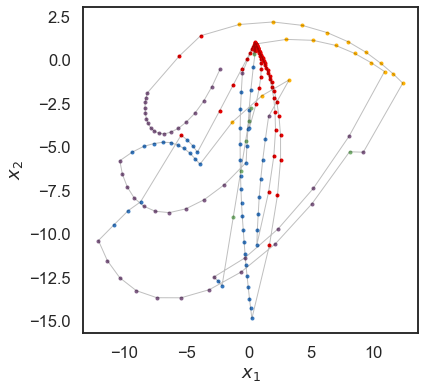

In [29]:
plt.figure(figsize=(6, 6))
idx = 5
obs = datas[idx]
zs = true_states[idx]
for k in range(num_states):
    plt.plot(obs[zs==k, 0], obs[zs==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(obs[:,0], obs[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Text(0, 0.5, '$x_2$')

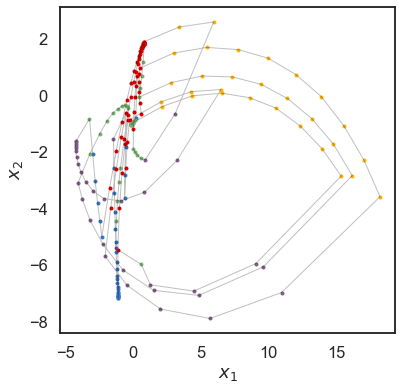

In [16]:
plt.figure(figsize=(6, 6))
idx = 0
obs = datas[idx]
zs = true_states[idx]
for k in range(num_states):
    plt.plot(obs[zs==k, 0], obs[zs==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(obs[:,0], obs[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the "true" values of the observation variable (the mean) while the solid lines are the actual observations sampled from the HMM.

In [17]:
# Compute the stationary point for each AR model
assert lags == 1
As = true_arhmm.observations.get_As(tags[idx])
bs = true_arhmm.observations.get_bs(tags[idx])
mus = np.linalg.solve(np.eye(obs_dim) - As, bs)

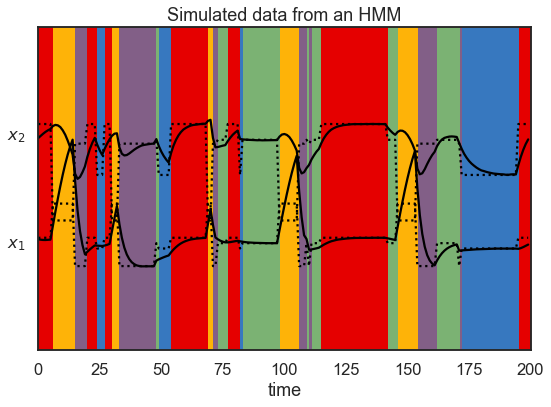

In [18]:
# Plot the data and the smoothed data
lim = 1.05 * abs(obs).max()
plt.figure(figsize=(8, 6))
plt.imshow(zs[None,:],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))


Ey = mus[zs]
for d in range(obs_dim):
    plt.plot(obs[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

plt.title("Simulated data from an HMM")

plt.tight_layout()


# 4. Fit an HMM to synthetic data

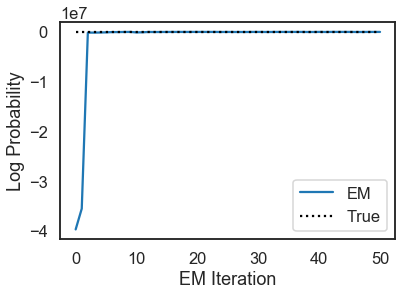

In [19]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 50

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, 
              observations="hierarchical_ar",
              observation_kwargs=dict(lags=lags, tags=tags))

hmm_lls = hmm.fit(datas, tags=tags, method="em", num_iters=N_iters)

plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [20]:
# Find a permutation of the states that best matches the true and inferred states
most_likely_states = [hmm.most_likely_states(data, tag=tag) 
                      for data, tag in zip(datas, tags)]

hmm.permute(find_permutation(np.concatenate(true_states), 
                             np.concatenate(most_likely_states)))

most_likely_states = [hmm.most_likely_states(data, tag=tag) 
                      for data, tag in zip(datas, tags)]

expected_states = [hmm.expected_states(data, tag=tag)[0]
                   for data, tag in zip(datas, tags)]

Below, we plot the inferred states ($z_{\mathrm{inferred}}$) and the true states ($z_{\mathrm{true}}$) over time. We see that the two match very closely, but not exactly. The model sometimes has difficulty inferring the state if we only observe that state for a very short time.

Dataset: 6 Tag: scott


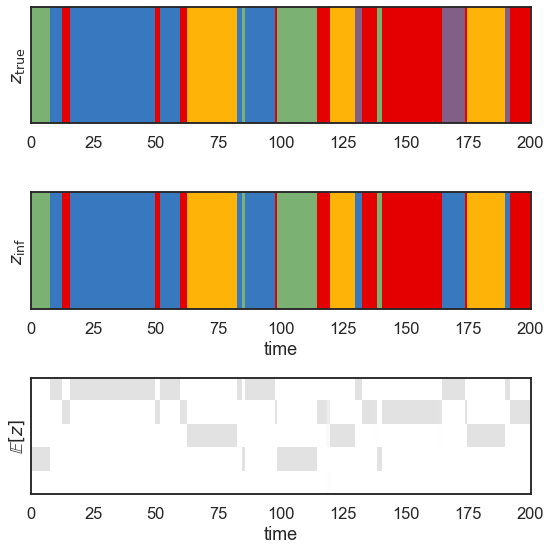

In [28]:
# Plot the true and inferred discrete states
idx = 6
print("Dataset: {} Tag: {}".format(idx, tags[idx]))

plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.imshow(true_states[idx][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(312)
plt.imshow(most_likely_states[idx][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inf}}$")
plt.yticks([])
plt.xlabel("time")

plt.subplot(313)
plt.imshow(expected_states[idx].T, aspect="auto", cmap="Greys", vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$\mathbb{E}[z]$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

Text(0.5, 0, 'time')

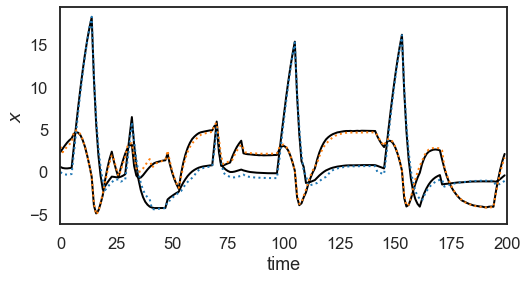

In [23]:
# Use the HMM to "smooth" the data
smooth_datas = [hmm.smooth(data, tag=tag) 
                for data, tag in zip(datas, tags)]

plt.figure(figsize=(8, 4))
plt.plot(datas[0] + 3 * np.arange(obs_dim), '-k', lw=2)
plt.plot(smooth_datas[0] + 3 * np.arange(obs_dim), ':', lw=2)
plt.xlim(0, time_bins)
plt.ylabel("$x$")
# plt.yticks([])
plt.xlabel("time")

### 4.1. Visualize the Transition Matrices
The dynamics of the hidden state in an HMM are specified by the transition probabilities $p(z_t \mid z_{t-1})$. It's standard to pack these probabilities into a stochastic matrix $A$ where $A_{ij} = p(z_t = j \mid z_{t-1} = i)$.

In SSM, we can access the transition matrices using `hmm.transitions.transition` matrix. In the following two lines, we retrives the transition matrices for the true HMM, as well as the HMM we learned from the data, and compare them visually.

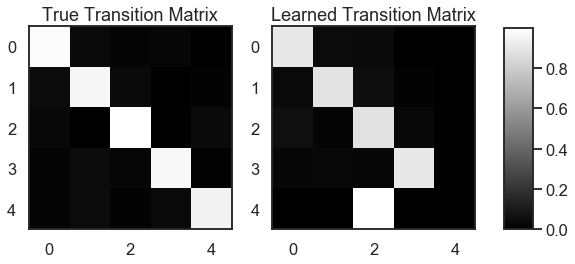

In [25]:
true_transition_mat = true_arhmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()
